In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pickle
import numpy as np
from pandas import Series, DataFrame
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import mlab
import seaborn as sns
%matplotlib inline

mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.direction'] = 'out'

In [3]:
def get_position_dict(df):
    df.reset_index(inplace=True)
    position_dict = {}
    position_dict['+']=[]
    position_dict['-']=[]
    for i in range(len(df)):
        if df.loc[i,'strand'] == '+':
            position_dict['+'].append(df.loc[i,'ATG'])
        if df.loc[i,'strand'] == '-':
            position_dict['-'].append(df.loc[i,'ATG'])
    return position_dict

In [4]:
def threshold(cut_off,readcountsf_plus, position, upstream_length,downstream_length):
    if sum(readcountsf_plus[position-upstream_length:position+downstream_length])>=cut_off:
        return 'yes'
    else:
        return 'no'

def each_gene_averagegene(rpm, position, upstream_length, downstream_length):
    each_averagegene=[0 for x in range(0,(upstream_length+downstream_length))]
    countlist = rpm[position-upstream_length-1:position+downstream_length-1]
    totcounts = sum(countlist)
    if totcounts!=0:
        i=0
        while i < len(countlist): 
            each_averagegene[i]+=countlist[i]/totcounts 
            i+=1
    return each_averagegene

def each_gene_averagegene_minus(rpm, position, upstream_length, downstream_length):
    each_averagegene=[0 for x in range(0,(upstream_length+downstream_length))]
    reverse_countlist = rpm[position-downstream_length:position+upstream_length]
    countlist = reverse_countlist[::-1]
    totcounts = sum(countlist)
    if totcounts!=0:
        i=0
        while i < len(countlist): 
            each_averagegene[i]+=countlist[i]/totcounts 
            i+=1
    return each_averagegene

def wrap_genes_GEN_averagegene(cut_off,readcounts,rpm,positions,upstream_length,downstream_length):
    AGP_data=[]
    
    readcounts_plus = readcounts[0][readcounts[0].keys()[0]]
    rpm_plus = rpm[0][rpm[0].keys()[0]]
    position_plus = positions['+']
    for position in position_plus:
        cut_off_result = threshold(cut_off,readcounts_plus,position,upstream_length,downstream_length)
        if cut_off_result == 'yes':         
            EachGeneAveragegene=each_gene_averagegene(rpm_plus,position,upstream_length,downstream_length)
            AGP_data.append(EachGeneAveragegene)
    
    readcounts_minus = readcounts[1][readcounts[1].keys()[0]]
    rpm_minus = rpm[1][rpm[1].keys()[0]]
    position_minus = positions['-']        
    for position in position_minus:
        cut_off_result = threshold(cut_off,readcounts_minus,position,downstream_length,upstream_length) # opposite as minus
        if cut_off_result == 'yes':         
            EachGeneAveragegene=each_gene_averagegene_minus(rpm_minus,position,upstream_length,downstream_length)
            AGP_data.append(EachGeneAveragegene)
    
    AGP_df=DataFrame(AGP_data)
    AGP_df.loc['average']=AGP_df.mean(axis=0)
    return AGP_df

In [5]:
def AGP_plotter(graph_downstream,graph_upstream,average_df,tick_distance,color):
    print len(average_df)
    x=np.arange(graph_downstream-graph_upstream)
    y=average_df.loc['average'][graph_upstream:graph_downstream]
    plt.plot(x,y, color=color,linewidth = 2)
    plt.xticks(np.arange(min(x), max(x)+1, tick_distance))

In [6]:
def RCRPM_loading(RC,RPM,filename,endtype,densitypath):
    with open(densitypath+filename+endtype+'_readcounts.pickle', 'rb') as f:
        RC[filename]=pickle.load(f)
    with open(densitypath+filename+endtype+'_rpm.pickle', 'rb') as f:
        RPM[filename]=pickle.load(f)
    #return [rcs,rpms]

In [7]:
import multiprocessing
import pickle
import threading
from datetime import datetime

print datetime.now()

#RC ={} somehow I need to do below to assign this dict to get the value evalutated from the RCRPM_loading
#RPM = {} somehow I need to do below to assign this dict to get the value evalutated from the RCRPM_loading
manager = multiprocessing.Manager()
RC = manager.dict()
RPM = manager.dict()

jobs = []

filenames = ['ks170','ks171','ks172','ks182ks110ks83']
endtype = '_3map'
densitypath = '/home/kazuki/^profilingdata/20190503/density_V_options_2/'
for filename in filenames:
    job = multiprocessing.Process(target=RCRPM_loading, args=(RC,RPM,filename,endtype,densitypath))
    jobs.append(job)
    job.start()       
    
[job.join() for job in jobs] # just to get the time by the below line

print datetime.now()    

2019-07-20 16:12:16.954665
2019-07-20 16:12:40.982256


# Genome positions of AUGs

In [8]:
outputfile2 = '/home/kazuki/^data_analysis/^Ecoli_Genome/Positions_ATG_InRNA.csv'
Positions_DataFrame = pd.read_csv(outputfile2)
Positions_DataFrame = Positions_DataFrame.loc[:,~Positions_DataFrame.columns.str.contains('^Unnamed')]

Start = Positions_DataFrame['At_start'].notnull()
notStart = Positions_DataFrame['At_start'].isnull()

inRNA = Positions_DataFrame['In_RNA']=='yes'
not_inRNA = Positions_DataFrame['In_RNA'].isnull()

# Thresh0ld and range

In [9]:
threshold_setting = 10
upstream_length_setting = 50
downstream_length_setting = 50
graph_upstream = upstream_length_setting-25
graph_downstream = upstream_length_setting+50
tick_distance=25

# Annotated AUG

778
1261


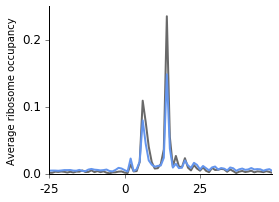

In [10]:
fig, ax = plt.subplots()
#fig.set_dpi(500)
fig.set_size_inches(4, 3)

positions = get_position_dict(Positions_DataFrame[Start&inRNA])

libraries = ['ks170','ks182ks110ks83']
colors = ['dimgrey','cornflowerblue']

for library,color in zip(libraries,colors):
    average_df=wrap_genes_GEN_averagegene(threshold_setting,RC[library],RPM[library],positions,upstream_length_setting,downstream_length_setting)
    AGP_plotter(graph_downstream,graph_upstream,average_df,tick_distance,color)
    
    
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
sns.despine()

plt.xticks([0,25,50],['-25','0','25'])
plt.ylim(0,0.25)
plt.yticks([0,0.1,0.2])
plt.tick_params(labelsize=12)
plt.ylabel('Average ribosome occupancy', fontsize=10)
#plt.savefig('fig_reta_AGPviolin/reta_start_Omut.pdf', dpi=500, bbox_inches="tight", pad_inches=0.05)

778
634


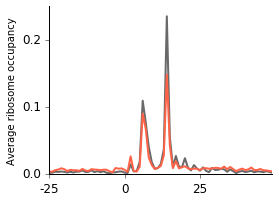

In [11]:
fig, ax = plt.subplots()
#fig.set_dpi(500)
fig.set_size_inches(4, 3)

positions = get_position_dict(Positions_DataFrame[Start&inRNA])

libraries = ['ks170','ks171']
colors = ['dimgrey','tomato']

for library,color in zip(libraries,colors):
    average_df=wrap_genes_GEN_averagegene(threshold_setting,RC[library],RPM[library],positions,upstream_length_setting,downstream_length_setting)
    AGP_plotter(graph_downstream,graph_upstream,average_df,tick_distance,color)
    
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
sns.despine()

plt.xticks([0,25,50],['-25','0','25'])
plt.ylim(0,0.25)
plt.yticks([0,0.1,0.2])
plt.tick_params(labelsize=12)
plt.ylabel('Average ribosome occupancy', fontsize=10)
#plt.savefig('fig_reta_AGPviolin/reta_start_Smut.pdf', dpi=500, bbox_inches="tight", pad_inches=0.05)

778
476


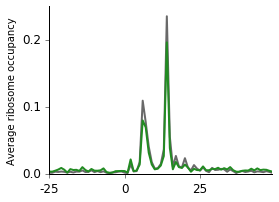

In [12]:
fig, ax = plt.subplots()
#fig.set_dpi(500)
fig.set_size_inches(4, 3)

positions = get_position_dict(Positions_DataFrame[Start&inRNA])

libraries = ['ks170','ks172']
colors = ['dimgrey','forestgreen']

for library,color in zip(libraries,colors):
    average_df=wrap_genes_GEN_averagegene(threshold_setting,RC[library],RPM[library],positions,upstream_length_setting,downstream_length_setting)
    AGP_plotter(graph_downstream,graph_upstream,average_df,tick_distance,color)
    
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
sns.despine()

plt.xticks([0,25,50],['-25','0','25'])
plt.ylim(0,0.25)
plt.yticks([0,0.1,0.2])
plt.tick_params(labelsize=12)
plt.ylabel('Average ribosome occupancy', fontsize=10)
#plt.savefig('fig_reta_AGPviolin/reta_start_Amut.pdf', dpi=500, bbox_inches="tight", pad_inches=0.05)

# NON-annotated AUG

4903
14372


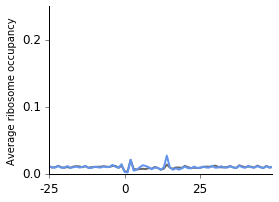

In [13]:
fig, ax = plt.subplots()
#fig.set_dpi(500)
fig.set_size_inches(4, 3)

positions = get_position_dict(Positions_DataFrame[notStart&inRNA])

libraries = ['ks170','ks182ks110ks83']
colors = ['dimgrey','cornflowerblue']

for library,color in zip(libraries,colors):
    average_df=wrap_genes_GEN_averagegene(threshold_setting,RC[library],RPM[library],positions,upstream_length_setting,downstream_length_setting)
    AGP_plotter(graph_downstream,graph_upstream,average_df,tick_distance,color)
    
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
sns.despine()

plt.xticks([0,25,50],['-25','0','25'])
plt.ylim(0,0.25)
plt.yticks([0,0.1,0.2])
plt.tick_params(labelsize=12)
plt.ylabel('Average ribosome occupancy', fontsize=10)
#plt.savefig('fig_reta_AGPviolin/reta_nonstart_Omut.pdf', dpi=500, bbox_inches="tight", pad_inches=0.05)

4903
5868


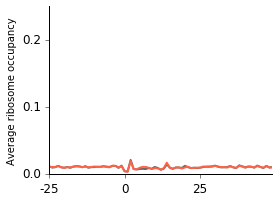

In [14]:
fig, ax = plt.subplots()
#fig.set_dpi(500)
fig.set_size_inches(4, 3)

positions = get_position_dict(Positions_DataFrame[notStart&inRNA])

libraries = ['ks170','ks171']
colors = ['dimgrey','tomato']

for library,color in zip(libraries,colors):
    average_df=wrap_genes_GEN_averagegene(threshold_setting,RC[library],RPM[library],positions,upstream_length_setting,downstream_length_setting)
    AGP_plotter(graph_downstream,graph_upstream,average_df,tick_distance,color)
    
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
sns.despine()

plt.xticks([0,25,50],['-25','0','25'])
plt.ylim(0,0.25)
plt.yticks([0,0.1,0.2])
plt.tick_params(labelsize=12) 
plt.ylabel('Average ribosome occupancy', fontsize=10)
#plt.savefig('fig_reta_AGPviolin/reta_nonstart_Smut.pdf', dpi=500, bbox_inches="tight", pad_inches=0.05)

4903
4509


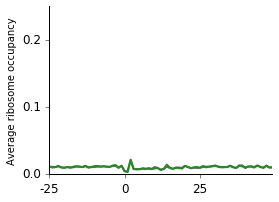

In [15]:
fig, ax = plt.subplots()
#fig.set_dpi(500)
fig.set_size_inches(4, 3)

positions = get_position_dict(Positions_DataFrame[notStart&inRNA])

libraries = ['ks170','ks172']
colors = ['dimgrey','forestgreen']

for library,color in zip(libraries,colors):
    average_df=wrap_genes_GEN_averagegene(threshold_setting,RC[library],RPM[library],positions,upstream_length_setting,downstream_length_setting)
    AGP_plotter(graph_downstream,graph_upstream,average_df,tick_distance,color)
    
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
sns.despine()

plt.xticks([0,25,50],['-25','0','25'])
plt.ylim(0,0.25)
plt.yticks([0,0.1,0.2])
plt.tick_params(labelsize=12)
plt.ylabel('Average ribosome occupancy', fontsize=10)
#plt.savefig('fig_reta_AGPviolin/reta_nonstart_Amut.pdf', dpi=500, bbox_inches="tight", pad_inches=0.05)